In [1]:
import os
import json
import shutil
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

# Set working directory to yolo folder
os.chdir(Path.cwd() / 'yolo' if 'yolo' not in str(Path.cwd()) else Path.cwd())
print(f"🔧 Working directory: {Path.cwd()}")

# Define paths relative to indian-traffic-ai folder
PROJECT_ROOT = Path.cwd().parent  # This should be indian-traffic-ai
DATA_ROOT = PROJECT_ROOT / "data" / "raw"
YOLO_OUTPUT = Path.cwd() / "yolo_data"

print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 Data root: {DATA_ROOT}")
print(f"📁 YOLO output: {YOLO_OUTPUT}")

# Vehicle classes for Indian traffic
CLASSES = {
    'auto_rickshaw': 0, 'auto rickshaw': 0, 'autorickshaw': 0,
    'bus': 1,
    'car': 2, 'sedan': 2, 'hatchback': 2,
    'motorcycle': 3, 'motorbike': 3, 'bike': 3,
    'scooter': 4,
    'truck': 5, 'lorry': 5
}

CLASS_NAMES = ['auto_rickshaw', 'bus', 'car', 'motorcycle', 'scooter', 'truck']

print(f"🚗 Vehicle classes: {CLASS_NAMES}")

🔧 Working directory: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo
📁 Project root: C:\Users\abhir\Downloads\urban\indian-traffic-ai
📁 Data root: C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw
📁 YOLO output: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data
🚗 Vehicle classes: ['auto_rickshaw', 'bus', 'car', 'motorcycle', 'scooter', 'truck']


In [2]:

## Cell 2: Check Available Data

def analyze_data_structure():
    """Analyze what data we have"""
    print("🔍 Analyzing Data Structure")
    print("=" * 40)
    
    analysis = {}
    
    for split in ['train', 'val', 'test']:
        split_path = DATA_ROOT / split
        analysis[split] = {
            'images': 0,
            'annotations': 0,
            'image_files': [],
            'anno_files': []
        }
        
        if split_path.exists():
            print(f"\n📂 {split.upper()} folder:")
            
            # Check for images
            img_folders = [split_path, split_path / "images"]
            for img_folder in img_folders:
                if img_folder.exists():
                    imgs = list(img_folder.glob("*.jpg")) + list(img_folder.glob("*.png"))
                    analysis[split]['image_files'].extend(imgs)
            
            # Check for annotations
            anno_folders = [split_path, split_path / "annos", split_path / "annotations"]
            for anno_folder in anno_folders:
                if anno_folder.exists():
                    annos = list(anno_folder.glob("*.json"))
                    analysis[split]['anno_files'].extend(annos)
            
            analysis[split]['images'] = len(analysis[split]['image_files'])
            analysis[split]['annotations'] = len(analysis[split]['anno_files'])
            
            print(f"   📸 Images: {analysis[split]['images']}")
            print(f"   📝 Annotations: {analysis[split]['annotations']}")
            
            if analysis[split]['image_files']:
                sample_files = [f.name for f in analysis[split]['image_files'][:3]]
                print(f"   📋 Sample files: {sample_files}")
        else:
            print(f"\n❌ {split.upper()} folder not found")
    
    return analysis

# Run analysis
data_analysis = analyze_data_structure()

# Show total summary
total_images = sum(data_analysis[split]['images'] for split in data_analysis)
total_annos = sum(data_analysis[split]['annotations'] for split in data_analysis)

print(f"\n📊 TOTAL SUMMARY:")
print(f"   📸 Total Images: {total_images}")
print(f"   📝 Total Annotations: {total_annos}")

if total_images == 0:
    print("\n❌ No data found! Please check your data structure.")
else:
    print(f"\n✅ Found data! Ready to proceed.")

🔍 Analyzing Data Structure

📂 TRAIN folder:
   📸 Images: 3535
   📝 Annotations: 0
   📋 Sample files: ['0.jpg', '1.jpg', '10.jpg']

📂 VAL folder:
   📸 Images: 884
   📝 Annotations: 0
   📋 Sample files: ['1002.jpg', '1013.jpg', '1015.jpg']

📂 TEST folder:
   📸 Images: 1083
   📝 Annotations: 0
   📋 Sample files: ['4810.jpg', '4811.jpg', '4812.jpg']

📊 TOTAL SUMMARY:
   📸 Total Images: 5502
   📝 Total Annotations: 0

✅ Found data! Ready to proceed.


In [4]:
def analyze_annotation_format():
    """Look at annotation format to understand the structure"""
    print("🔍 Analyzing Annotation Format")
    print("=" * 35)
    
    # Check if data_analysis exists and has annotation files
    if 'data_analysis' not in globals():
        print("❌ Please run Cell 2 first to analyze data structure")
        return None
    
    # Find first annotation file from any split
    anno_file = None
    for split in ['train', 'val', 'test']:
        if split in data_analysis and data_analysis[split]['anno_files']:
            anno_file = data_analysis[split]['anno_files'][0]
            break
    
    if anno_file is None:
        print("❌ No annotation files found in any split")
        print("🔍 Let me check what files exist:")
        
        # Debug: show what files are actually in the directories
        for split in ['train', 'val', 'test']:
            split_path = DATA_ROOT / split
            if split_path.exists():
                print(f"\n📂 {split_path}:")
                for item in split_path.iterdir():
                    if item.is_dir():
                        print(f"   📁 {item.name}/")
                        # Show contents of subdirectories
                        for subitem in item.iterdir():
                            print(f"      📄 {subitem.name}")
                    else:
                        print(f"   📄 {item.name}")
        return None
    
    print(f"📝 Analyzing: {anno_file}")
    
    try:
        with open(anno_file, 'r') as f:
            data = json.load(f)
        
        print(f"📋 File structure:")
        if isinstance(data, dict):
            print(f"   Type: Dictionary")
            print(f"   Keys: {list(data.keys())}")
            
            # Show first few items of each key
            for key, value in data.items():
                if isinstance(value, list) and value:
                    print(f"   {key}: List with {len(value)} items")
                    if isinstance(value[0], dict):
                        print(f"      First item keys: {list(value[0].keys())}")
                else:
                    print(f"   {key}: {type(value).__name__}")
        
        elif isinstance(data, list):
            print(f"   Type: List with {len(data)} items")
            if data and isinstance(data[0], dict):
                print(f"   First item keys: {list(data[0].keys())}")
        
        # Show sample
        print(f"\n👀 Sample content:")
        sample_str = json.dumps(data, indent=2)[:500]
        print(f"{sample_str}...")
        
        return data
        
    except Exception as e:
        print(f"❌ Error reading annotation: {e}")
        return None

# Analyze annotations
sample_annotation = analyze_annotation_format()

🔍 Analyzing Annotation Format
❌ No annotation files found in any split
🔍 Let me check what files exist:

📂 C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw\train:
   📁 annos/
      📄 0.xml
      📄 1.xml
      📄 10.xml
      📄 100.xml
      📄 1000.xml
      📄 1001.xml
      📄 1003.xml
      📄 1004.xml
      📄 1005.xml
      📄 1006.xml
      📄 1007.xml
      📄 1008.xml
      📄 101.xml
      📄 1010.xml
      📄 1011.xml
      📄 1012.xml
      📄 1016.xml
      📄 1017.xml
      📄 1018.xml
      📄 1019.xml
      📄 102.xml
      📄 1020.xml
      📄 1021.xml
      📄 1023.xml
      📄 1026.xml
      📄 1027.xml
      📄 1028.xml
      📄 1029.xml
      📄 103.xml
      📄 1031.xml
      📄 1032.xml
      📄 1033.xml
      📄 1034.xml
      📄 1036.xml
      📄 1037.xml
      📄 1038.xml
      📄 1039.xml
      📄 104.xml
      📄 1040.xml
      📄 1041.xml
      📄 1042.xml
      📄 1043.xml
      📄 1044.xml
      📄 1045.xml
      📄 1046.xml
      📄 1047.xml
      📄 1049.xml
      📄 105.xml
      📄 1052.x

In [5]:
def setup_yolo_directories():
    """Create YOLO format directory structure"""
    print("📁 Setting up YOLO directories...")
    
    directories = [
        YOLO_OUTPUT / "images" / "train",
        YOLO_OUTPUT / "images" / "val",
        YOLO_OUTPUT / "images" / "test",
        YOLO_OUTPUT / "labels" / "train",
        YOLO_OUTPUT / "labels" / "val",
        YOLO_OUTPUT / "labels" / "test",
        Path.cwd() / "models",
        Path.cwd() / "runs"
    ]
    
    for directory in directories:
        directory.mkdir(parents=True, exist_ok=True)
        print(f"   ✅ {directory}")
    
    print("✅ YOLO directories created!")

setup_yolo_directories()

📁 Setting up YOLO directories...
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\images\train
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\images\val
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\images\test
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\train
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\val
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\test
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\models
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs
✅ YOLO directories created!


In [6]:
def debug_data_structure():
    """Debug what's actually in your data folders"""
    print("🔍 DEBUG: Let's see what's actually in your data folders")
    print("=" * 55)
    
    print(f"📁 Looking in: {DATA_ROOT}")
    
    if not DATA_ROOT.exists():
        print(f"❌ DATA_ROOT doesn't exist: {DATA_ROOT}")
        # Try to find data folder
        possible_data_roots = [
            Path.cwd().parent / "data" / "raw",
            Path.cwd() / ".." / "data" / "raw", 
            Path.cwd() / "data" / "raw",
            Path.cwd().parent.parent / "data" / "raw"
        ]
        
        print("🔍 Searching for data folder in:")
        for possible_root in possible_data_roots:
            abs_path = possible_root.resolve()
            print(f"   {abs_path} - {'EXISTS' if abs_path.exists() else 'NOT FOUND'}")
            if abs_path.exists():
                print(f"   ✅ Found data at: {abs_path}")
                return abs_path
        return None
    
    print(f"✅ DATA_ROOT exists: {DATA_ROOT}")
    
    # Show directory tree
    def show_tree(path, prefix="", max_depth=3, current_depth=0):
        if current_depth >= max_depth:
            return
        
        if not path.exists():
            return
            
        items = list(path.iterdir())
        for i, item in enumerate(items):
            is_last = i == len(items) - 1
            current_prefix = "└── " if is_last else "├── "
            print(f"{prefix}{current_prefix}{item.name}")
            
            if item.is_dir() and current_depth < max_depth - 1:
                extension = "    " if is_last else "│   "
                show_tree(item, prefix + extension, max_depth, current_depth + 1)
    
    print(f"\n📂 Directory structure:")
    show_tree(DATA_ROOT)
    
    return DATA_ROOT

# Run debug
actual_data_root = debug_data_structure()

# Update DATA_ROOT if we found it elsewhere
if actual_data_root and actual_data_root != DATA_ROOT:
    DATA_ROOT = actual_data_root
    print(f"\n🔄 Updated DATA_ROOT to: {DATA_ROOT}")
    
    # Re-run data analysis with correct path
    print(f"\n🔄 Re-analyzing data with correct path...")
    data_analysis = analyze_data_structure()

🔍 DEBUG: Let's see what's actually in your data folders
📁 Looking in: C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw
✅ DATA_ROOT exists: C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw

📂 Directory structure:
├── test
│   ├── annos
│   │   ├── 4810.xml
│   │   ├── 4811.xml
│   │   ├── 4812.xml
│   │   ├── 4813.xml
│   │   ├── 4814.xml
│   │   ├── 4815.xml
│   │   ├── 4816.xml
│   │   ├── 4817.xml
│   │   ├── 4818.xml
│   │   ├── 4819.xml
│   │   ├── 4820.xml
│   │   ├── 4821.xml
│   │   ├── 4822.xml
│   │   ├── 4823.xml
│   │   ├── 4824.xml
│   │   ├── 4825.xml
│   │   ├── 4826.xml
│   │   ├── 4827.xml
│   │   ├── 4828.xml
│   │   ├── 4829.xml
│   │   ├── 4830.xml
│   │   ├── 4831.xml
│   │   ├── 4832.xml
│   │   ├── 4833.xml
│   │   ├── 4834.xml
│   │   ├── 4835.xml
│   │   ├── 4836.xml
│   │   ├── 4837.xml
│   │   ├── 4838.xml
│   │   ├── 4839.xml
│   │   ├── 4840.xml
│   │   ├── 4842.xml
│   │   ├── 4843.xml
│   │   ├── 4844.xml
│   │   ├── 4846.xml
│   │   ├── 

In [9]:
def debug_conversion_issues():
    """Debug why no data was converted"""
    print("🔍 DEBUGGING: Why no data was converted")
    print("=" * 45)
    
    # Check if data_analysis exists
    if 'data_analysis' not in globals():
        print("❌ data_analysis not found - run Cell 2 first")
        return
    
    # Check what data_analysis contains
    print("📊 Data analysis results:")
    for split, info in data_analysis.items():
        print(f"\n📂 {split.upper()}:")
        print(f"   Images: {info['images']}")
        print(f"   Annotations: {info['annotations']}")
        
        if info['image_files']:
            print(f"   Sample image: {info['image_files'][0]}")
            print(f"   Image exists: {info['image_files'][0].exists()}")
        
        if info['anno_files']:
            print(f"   Sample annotation: {info['anno_files'][0]}")
            print(f"   Annotation exists: {info['anno_files'][0].exists()}")
            
            # Try to read first annotation
            try:
                with open(info['anno_files'][0], 'r') as f:
                    sample_anno = json.load(f)
                print(f"   ✅ Can read annotation")
                print(f"   📋 Annotation type: {type(sample_anno)}")
                
                if isinstance(sample_anno, dict):
                    print(f"   🔑 Keys: {list(sample_anno.keys())}")
                elif isinstance(sample_anno, list) and sample_anno:
                    print(f"   📝 List length: {len(sample_anno)}")
                    if isinstance(sample_anno[0], dict):
                        print(f"   🔑 First item keys: {list(sample_anno[0].keys())}")
                        
            except Exception as e:
                print(f"   ❌ Cannot read annotation: {e}")
    
    # Check YOLO output directories
    print(f"\n📁 YOLO Output directories:")
    for split in ['train', 'val', 'test']:
        img_dir = YOLO_OUTPUT / "images" / split
        label_dir = YOLO_OUTPUT / "labels" / split
        
        img_count = len(list(img_dir.glob("*"))) if img_dir.exists() else 0
        label_count = len(list(label_dir.glob("*"))) if label_dir.exists() else 0
        
        print(f"   {split}: {img_count} images, {label_count} labels")

# Run debug
debug_conversion_issues()

🔍 DEBUGGING: Why no data was converted
📊 Data analysis results:

📂 TRAIN:
   Images: 3535
   Annotations: 0
   Sample image: C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw\train\images\0.jpg
   Image exists: True

📂 VAL:
   Images: 884
   Annotations: 0
   Sample image: C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw\val\images\1002.jpg
   Image exists: True

📂 TEST:
   Images: 1083
   Annotations: 0
   Sample image: C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw\test\images\4810.jpg
   Image exists: True

📁 YOLO Output directories:
   train: 0 images, 0 labels
   val: 0 images, 0 labels
   test: 0 images, 0 labels


In [12]:
import xml.etree.ElementTree as ET

def analyze_xml_annotation_format():
    """Analyze XML annotation format"""
    print("🔍 ANALYZING XML ANNOTATION FORMAT")
    print("=" * 40)
    
    # Find first XML annotation
    sample_xml = None
    for split in ['train', 'val', 'test']:
        split_path = DATA_ROOT / split / "annos"
        if split_path.exists():
            xml_files = list(split_path.glob("*.xml"))
            if xml_files:
                sample_xml = xml_files[0]
                break
    
    if not sample_xml:
        print("❌ No XML annotation files found")
        return None
    
    print(f"📝 Analyzing: {sample_xml}")
    
    try:
        tree = ET.parse(sample_xml)
        root = tree.getroot()
        
        print(f"📋 XML structure:")
        print(f"   Root tag: {root.tag}")
        
        # Show all child tags
        child_tags = [child.tag for child in root]
        print(f"   Child tags: {set(child_tags)}")
        
        # Look for image info
        filename = root.find('filename')
        if filename is not None:
            print(f"   📸 Filename: {filename.text}")
        
        size = root.find('size')
        if size is not None:
            width = size.find('width')
            height = size.find('height')
            if width is not None and height is not None:
                print(f"   📏 Image size: {width.text}x{height.text}")
        
        # Look for objects
        objects = root.findall('object')
        print(f"   🎯 Objects found: {len(objects)}")
        
        if objects:
            first_obj = objects[0]
            print(f"\n📦 First object structure:")
            
            name = first_obj.find('name')
            if name is not None:
                print(f"   🏷️ Class: {name.text}")
            
            bndbox = first_obj.find('bndbox')
            if bndbox is not None:
                xmin = bndbox.find('xmin')
                ymin = bndbox.find('ymin')
                xmax = bndbox.find('xmax')
                ymax = bndbox.find('ymax')
                
                if all(coord is not None for coord in [xmin, ymin, xmax, ymax]):
                    print(f"   📦 Bbox: [{xmin.text}, {ymin.text}, {xmax.text}, {ymax.text}]")
        
        # Show full XML content (first few lines)
        with open(sample_xml, 'r') as f:
            xml_content = f.read()
        
        print(f"\n📄 XML Content (first 500 chars):")
        print("-" * 30)
        print(xml_content[:500])
        print("-" * 30)
        
        return root
        
    except Exception as e:
        print(f"❌ Error parsing XML: {e}")
        return None

# Analyze XML format
xml_sample = analyze_xml_annotation_format()

🔍 ANALYZING XML ANNOTATION FORMAT
📝 Analyzing: C:\Users\abhir\Downloads\urban\indian-traffic-ai\data\raw\train\annos\0.xml
📋 XML structure:
   Root tag: annotation
   Child tags: {'source', 'object', 'folder', 'filename', 'segmented', 'size'}
   📸 Filename: IDD_finegrained/Main_part/5206-6234/Images/5393.jpg
   📏 Image size: 1920x1080
   🎯 Objects found: 2

📦 First object structure:
   🏷️ Class: motorcycle_Honda_Shine
   📦 Bbox: [996.0, 619.0, 1086.0, 752.0]

📄 XML Content (first 500 chars):
------------------------------
<annotation>
  <folder>IDD</folder>
  <filename>IDD_finegrained/Main_part/5206-6234/Images/5393.jpg</filename>
  <source>
    <database>Unknown</database>
    <annotation>Unknown</annotation>
    <image>Unknown</image>
  </source>
  <size>
    <width>1920</width>
    <height>1080</height>
    <depth />
  </size>
  <segmented>0</segmented>
  <object>
    <name>motorcycle_Honda_Shine</name>
    <truncated>0</truncated>
    <occluded>0</occluded>
    <difficult>0</diffic

In [13]:
def analyze_data_structure_xml():
    """Analyze data structure looking for XML files"""
    print("🔍 Analyzing Data Structure (XML Version)")
    print("=" * 45)
    
    analysis = {}
    
    for split in ['train', 'val', 'test']:
        split_path = DATA_ROOT / split
        analysis[split] = {
            'images': 0,
            'annotations': 0,
            'image_files': [],
            'anno_files': []
        }
        
        if split_path.exists():
            print(f"\n📂 {split.upper()} folder:")
            
            # Check for images
            img_dir = split_path / "images"
            if img_dir.exists():
                imgs = list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png"))
                analysis[split]['image_files'].extend(imgs)
                print(f"   📸 Images: {len(imgs)}")
            
            # Check for XML annotations
            anno_dir = split_path / "annos"
            if anno_dir.exists():
                xml_files = list(anno_dir.glob("*.xml"))
                analysis[split]['anno_files'].extend(xml_files)
                print(f"   📝 XML Annotations: {len(xml_files)}")
            
            analysis[split]['images'] = len(analysis[split]['image_files'])
            analysis[split]['annotations'] = len(analysis[split]['anno_files'])
            
            print(f"   📊 Total - Images: {analysis[split]['images']}, Annotations: {analysis[split]['annotations']}")
            
            # Check for matching files
            if analysis[split]['image_files'] and analysis[split]['anno_files']:
                img_stems = {f.stem for f in analysis[split]['image_files']}
                anno_stems = {f.stem for f in analysis[split]['anno_files']}
                matching = img_stems & anno_stems
                print(f"   🔗 Matching pairs: {len(matching)}")
        else:
            print(f"\n❌ {split.upper()} folder not found")
    
    return analysis

# Update data analysis for XML
data_analysis_xml = analyze_data_structure_xml()

# Show total summary
total_images = sum(data_analysis_xml[split]['images'] for split in data_analysis_xml)
total_annos = sum(data_analysis_xml[split]['annotations'] for split in data_analysis_xml)

print(f"\n📊 TOTAL SUMMARY (XML):")
print(f"   📸 Total Images: {total_images}")
print(f"   📝 Total XML Annotations: {total_annos}")

if total_images > 0 and total_annos > 0:
    print(f"\n✅ Found XML data! Ready to convert.")
else:
    print(f"\n❌ Still missing data.")

🔍 Analyzing Data Structure (XML Version)

📂 TRAIN folder:
   📸 Images: 3535
   📝 XML Annotations: 3535
   📊 Total - Images: 3535, Annotations: 3535
   🔗 Matching pairs: 3535

📂 VAL folder:
   📸 Images: 884
   📝 XML Annotations: 884
   📊 Total - Images: 884, Annotations: 884
   🔗 Matching pairs: 884

📂 TEST folder:
   📸 Images: 1083
   📝 XML Annotations: 1083
   📊 Total - Images: 1083, Annotations: 1083
   🔗 Matching pairs: 1083

📊 TOTAL SUMMARY (XML):
   📸 Total Images: 5502
   📝 Total XML Annotations: 5502

✅ Found XML data! Ready to convert.


In [14]:
class XMLToYOLOConverter:
    def __init__(self):
        # Vehicle class mapping - you may need to adjust these based on your XML class names
        self.class_mapping = {
            'auto_rickshaw': 0, 'auto rickshaw': 0, 'autorickshaw': 0, 'rickshaw': 0,
            'bus': 1,
            'car': 2, 'sedan': 2, 'hatchback': 2,
            'motorcycle': 3, 'motorbike': 3, 'bike': 3, 'motor cycle': 3,
            'scooter': 4,
            'truck': 5, 'lorry': 5
        }
        self.class_names = ['auto_rickshaw', 'bus', 'car', 'motorcycle', 'scooter', 'truck']
        self.converted_count = 0
        self.error_count = 0
        self.class_stats = {cls: 0 for cls in self.class_names}
        self.unknown_classes = set()
    
    def parse_xml_annotation(self, xml_file):
        """Parse XML annotation file"""
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # Get image dimensions
            size_elem = root.find('size')
            if size_elem is None:
                return None, None, None
            
            width_elem = size_elem.find('width')
            height_elem = size_elem.find('height')
            
            if width_elem is None or height_elem is None:
                return None, None, None
            
            img_width = int(width_elem.text)
            img_height = int(height_elem.text)
            
            # Get all objects
            objects = []
            for obj_elem in root.findall('object'):
                # Get class name
                name_elem = obj_elem.find('name')
                if name_elem is None:
                    continue
                
                class_name = name_elem.text.lower().strip()
                
                # Get bounding box
                bndbox_elem = obj_elem.find('bndbox')
                if bndbox_elem is None:
                    continue
                
                xmin_elem = bndbox_elem.find('xmin')
                ymin_elem = bndbox_elem.find('ymin')
                xmax_elem = bndbox_elem.find('xmax')
                ymax_elem = bndbox_elem.find('ymax')
                
                if any(elem is None for elem in [xmin_elem, ymin_elem, xmax_elem, ymax_elem]):
                    continue
                
                try:
                    xmin = float(xmin_elem.text)
                    ymin = float(ymin_elem.text)
                    xmax = float(xmax_elem.text)
                    ymax = float(ymax_elem.text)
                    
                    objects.append({
                        'class': class_name,
                        'bbox': [xmin, ymin, xmax, ymax]
                    })
                except ValueError:
                    continue
            
            return img_width, img_height, objects
            
        except Exception as e:
            print(f"      ❌ XML parse error: {e}")
            return None, None, None
    
    def convert_bbox_to_yolo(self, bbox, img_width, img_height):
        """Convert Pascal VOC bbox to YOLO format"""
        xmin, ymin, xmax, ymax = bbox
        
        # Calculate center and dimensions
        center_x = (xmin + xmax) / 2 / img_width
        center_y = (ymin + ymax) / 2 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        
        # Ensure values are in [0, 1]
        center_x = max(0, min(1, center_x))
        center_y = max(0, min(1, center_y))
        width = max(0, min(1, width))
        height = max(0, min(1, height))
        
        # Skip if bbox is too small
        if width < 0.001 or height < 0.001:
            return None
        
        return center_x, center_y, width, height
    
    def convert_single_file(self, img_file, xml_file, split):
        """Convert one image-XML pair"""
        try:
            # Parse XML
            img_width, img_height, objects = self.parse_xml_annotation(xml_file)
            
            if img_width is None or not objects:
                return False, 0
            
            # Convert objects to YOLO format
            yolo_lines = []
            valid_objects = 0
            
            for obj in objects:
                class_name = obj['class']
                
                # Map class name
                mapped_class = None
                if class_name in self.class_mapping:
                    mapped_class = class_name
                else:
                    # Try some variations
                    class_variations = {
                        'auto': 'auto_rickshaw',
                        'rickshaw': 'auto_rickshaw', 
                        'auto-rickshaw': 'auto_rickshaw',
                        'motor': 'motorcycle',
                        'bike': 'motorcycle',
                        'motorbike': 'motorcycle'
                    }
                    
                    for variation, mapped in class_variations.items():
                        if variation in class_name:
                            mapped_class = mapped
                            break
                
                if mapped_class is None:
                    self.unknown_classes.add(class_name)
                    continue
                
                class_id = self.class_mapping[mapped_class]
                
                # Convert bbox
                yolo_bbox = self.convert_bbox_to_yolo(obj['bbox'], img_width, img_height)
                if yolo_bbox is None:
                    continue
                
                center_x, center_y, width, height = yolo_bbox
                yolo_line = f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}"
                yolo_lines.append(yolo_line)
                
                # Update stats
                self.class_stats[self.class_names[class_id]] += 1
                valid_objects += 1
            
            if not yolo_lines:
                return False, 0
            
            # Copy image
            dest_img = YOLO_OUTPUT / "images" / split / img_file.name
            shutil.copy2(img_file, dest_img)
            
            # Save YOLO label
            dest_label = YOLO_OUTPUT / "labels" / split / f"{img_file.stem}.txt"
            with open(dest_label, 'w') as f:
                f.write('\n'.join(yolo_lines))
            
            self.converted_count += 1
            return True, valid_objects
            
        except Exception as e:
            self.error_count += 1
            print(f"      ❌ Error with {img_file.name}: {e}")
            return False, 0
    
    def convert_split(self, split):
        """Convert all data for one split"""
        print(f"\n🔄 Converting {split.upper()} XML data...")
        
        if split not in data_analysis_xml:
            print(f"   ⚠️ No data found for {split}")
            return 0
        
        images = data_analysis_xml[split]['image_files']
        annotations = data_analysis_xml[split]['anno_files']
        
        if not images or not annotations:
            print(f"   ⚠️ Missing images or annotations for {split}")
            return 0
        
        print(f"   📸 Processing {len(images)} images...")
        
        converted = 0
        total_objects = 0
        
        # Create mapping of file stems
        anno_map = {anno.stem: anno for anno in annotations}
        
        for img_file in tqdm(images, desc=f"Converting {split}"):
            img_stem = img_file.stem
            
            if img_stem in anno_map:
                success, obj_count = self.convert_single_file(img_file, anno_map[img_stem], split)
                if success:
                    converted += 1
                    total_objects += obj_count
            else:
                print(f"      ⚠️ No XML annotation for {img_file.name}")
        
        print(f"   ✅ Converted {converted}/{len(images)} images")
        print(f"   🎯 Total objects: {total_objects}")
        return converted

# Run XML conversion
print("🔄 Starting XML to YOLO conversion...")
xml_converter = XMLToYOLOConverter()

total_converted = 0
for split in ['train', 'val', 'test']:
    if split in data_analysis_xml and data_analysis_xml[split]['images'] > 0:
        converted = xml_converter.convert_split(split)
        total_converted += converted

print(f"\n📊 XML CONVERSION SUMMARY:")
print(f"   ✅ Total images converted: {total_converted}")
print(f"   ❌ Errors: {xml_converter.error_count}")
print(f"   🚗 Objects per class:")
for class_name, count in xml_converter.class_stats.items():
    if count > 0:
        print(f"      {class_name}: {count}")

if xml_converter.unknown_classes:
    print(f"   ⚠️ Unknown classes found: {xml_converter.unknown_classes}")
    print("   💡 You may need to update the class mapping")

🔄 Starting XML to YOLO conversion...

🔄 Converting TRAIN XML data...
   📸 Processing 3535 images...


Converting train: 100%|██████████| 3535/3535 [02:57<00:00, 19.95it/s]


   ✅ Converted 2897/3535 images
   🎯 Total objects: 7210

🔄 Converting VAL XML data...
   📸 Processing 884 images...


Converting val: 100%|██████████| 884/884 [00:42<00:00, 20.85it/s]


   ✅ Converted 711/884 images
   🎯 Total objects: 1747

🔄 Converting TEST XML data...
   📸 Processing 1083 images...


Converting test: 100%|██████████| 1083/1083 [00:54<00:00, 19.76it/s]

   ✅ Converted 893/1083 images
   🎯 Total objects: 2241

📊 XML CONVERSION SUMMARY:
   ✅ Total images converted: 4501
   ❌ Errors: 0
   🚗 Objects per class:
      auto_rickshaw: 3777
      bus: 1215
      motorcycle: 6206
   ⚠️ Unknown classes found: {'car_renault_duster', 'car_marutisuzuki_ertiga', 'car_marutisuzuki_1000', 'car_mercedes-benz_c-class', 'scooter_bajaj_chetak', 'car_marutisuzuki_celerio', 'car_ford_aspire', 'car_skoda_fabia', 'car_chevrolet_enjoy', 'mini-bus_others', 'car_honda_accord', 'car_chevrolet_tavera', 'truck_others', 'scooter_suzuki_access', 'car_hyundai_i20', 'car_skoda_superb', 'truck_ashokleyland', 'car_marutisuzuki_baleno', 'scooter_suzuki_burgman', 'scooter_honda_activa', 'car_volkswagen_ameo', 'car_ford_ecosporttitanium', 'car_marutisuzuki_omni', 'car_marutisuzuki_alto800', 'scooter_hero_duet', 'car_renault_lodgy', 'scooter_tvs_ntorq', 'car_volvo_xc60', 'car_mercedes-benz_a-class', 'car_marutisuzuki_ignis', 'truck_tata', 'car_volkswagen_vento', 'car_marutis

In [15]:
def update_class_mapping_and_reconvert():
    """Update class mapping to include specific vehicle types and reconvert"""
    print("🔄 UPDATING CLASS MAPPING FOR BETTER COVERAGE")
    print("=" * 50)
    
    # Enhanced class mapping that captures more specific vehicle types
    enhanced_mapping = {
        # Auto rickshaw
        'auto_rickshaw': 0, 'auto rickshaw': 0, 'autorickshaw': 0, 'rickshaw': 0,
        
        # Bus (including mini-bus)
        'bus': 1,
        'mini-bus_others': 1, 'mini_bus': 1, 'minibus': 1,
        
        # Cars (all car variants -> car)
        'car': 2,
        # Map all specific car types to general 'car'
        'car_renault_duster': 2, 'car_marutisuzuki_ertiga': 2, 'car_marutisuzuki_1000': 2,
        'car_mercedes-benz_c-class': 2, 'car_marutisuzuki_celerio': 2, 'car_ford_aspire': 2,
        'car_skoda_fabia': 2, 'car_chevrolet_enjoy': 2, 'car_honda_accord': 2,
        'car_chevrolet_tavera': 2, 'car_hyundai_i20': 2, 'car_skoda_superb': 2,
        'car_marutisuzuki_baleno': 2, 'car_volkswagen_ameo': 2, 'car_ford_ecosporttitanium': 2,
        'car_marutisuzuki_omni': 2, 'car_marutisuzuki_alto800': 2, 'car_renault_lodgy': 2,
        'car_volvo_xc60': 2, 'car_mercedes-benz_a-class': 2, 'car_marutisuzuki_ignis': 2,
        'car_volkswagen_vento': 2, 'car_marutisuzuki_dzire': 2, 'car_jeep_compass': 2,
        'car_fiat_linea': 2, 'car_honda_wr-v': 2, 'car_fiat_puntoevo': 2,
        'car_honda_jazz': 2, 'car_mahindra_reva': 2, 'car_chevrolet_spark': 2,
        'car_audi_a3': 2, 'car_marutisuzuki_ciaz': 2, 'car_mahindra_verito': 2,
        'car_skoda_rapid': 2, 'car_others': 2, 'car_bmw_x1': 2, 'car_ford_figo': 2,
        'car_ford_ecosport': 2, 'car_hyundai_santro': 2, 'car_marutisuzuki_sx4': 2,
        'car_audi_q3': 2, 'car_hindustan_ambassador': 2, 'car_hyundai_eon': 2,
        'car_marutisuzuki_ritz': 2, 'car_ford_fiesta': 2, 'car_honda_brv': 2,
        'car_chevrolet_beat': 2, 'car_toyota_qualis': 2, 'car_volkswagen_polo': 2,
        'car_skoda_octavia': 2, 'car_honda_amaze': 2, 'car_nissan_sunny': 2,
        'car_jeep_wrangler': 2, 'car_honda_cr-v': 2, 'car_renault_logan': 2,
        'car_mahindra_xuv500': 2, 'car_mercedes-benz_e-class': 2, 'car_toyota_fortuner': 2,
        'car_marutisuzuki_eeco': 2, 'car_toyota_innova': 2, 'car_ford_everest': 2,
        'car_marutisuzuki_swift': 2, 'car_nissan_micra': 2, 'car_mahindra_xylo': 2,
        'car_renault_kwid': 2, 'car_hyundai_xcent': 2, 'car_honda_brio': 2,
        'car_bmw_2-series-220d': 2, 'car_hyundai_accent': 2, 'car_hyundai_creta': 2,
        'car_mercedes-benz_amggt4-doorcoupe': 2, 'car_mercedes-benz_s-class': 2,
        'car_marutisuzuki_vitarabrezza': 2, 'car_mahindra_bolero': 2, 'car_hyundai_verna': 2,
        'car_mahindra_scorpio': 2, 'car_toyota_etiosliva': 2, 'car_covered': 2,
        'car_honda_city': 2, 'car_hyundai_i10': 2, 'car_mercedes-benz_gla-class': 2,
        'car_marutisuzuki_esteem2000': 2, 'car_nissan_terrano': 2, 'car_marutisuzuki_altok10': 2,
        'car_chevrolet_cruze': 2, 'car_mercedes-benz_g-class': 2, 'car_marutisuzuki_s-cross': 2,
        'car_honda_civic': 2, 'car_renault_scala': 2, 'car_marutisuzuki_wagonr': 2,
        'car_force_traxtoofan': 2, 'car_toyota_corolla': 2, 'car_volkswagen_jetta': 2,
        'car_marutisuzuki_zen': 2, 'car_chevrolet_aveo': 2, 'car_volvo_xc40': 2,
        'car_mahindra_tuv300': 2, 'car_bmw_3-series': 2, 'car_toyota_etios': 2,
        'car_ford_ikon': 2,
        
        # Motorcycles
        'motorcycle': 3, 'motorbike': 3, 'bike': 3, 'motor cycle': 3,
        
        # Scooters (all scooter variants -> scooter)
        'scooter': 4,
        'scooter_bajaj_chetak': 4, 'scooter_suzuki_access': 4, 'scooter_suzuki_burgman': 4,
        'scooter_honda_activa': 4, 'scooter_hero_duet': 4, 'scooter_tvs_ntorq': 4,
        'scooter_yamaha_rayzr': 4, 'scooter_tvs_pep': 4, 'scooter_honda_grazia': 4,
        'scooter_yamaha_fascino125': 4, 'scooter_hero_pleasure': 4, 'scooter_tvs_zest': 4,
        'scooter_honda_dio': 4, 'scooter_others': 4, 'scooter_suzuki_swish': 4,
        'scooter_tvs_streak': 4, 'scooter_vespa_vxl125': 4, 'scooter_tvs_jupiter': 4,
        'scooter_mahindra_gusto': 4, 'scooter_honda_aviator': 4, 'scooter_tvs_wego': 4,
        'scooter_hero_maestro': 4,
        
        # Trucks (all truck variants -> truck)
        'truck': 5,
        'truck_others': 5, 'truck_ashokleyland': 5, 'truck_tata': 5, 'truck_bharatbenz': 5,
        'truck_eicher': 5, 'truck_mahindra': 5, 'truck_sml': 5
    }
    
    return enhanced_mapping

# Create enhanced converter
class EnhancedXMLToYOLOConverter(XMLToYOLOConverter):
    def __init__(self):
        self.class_mapping = update_class_mapping_and_reconvert()
        self.class_names = ['auto_rickshaw', 'bus', 'car', 'motorcycle', 'scooter', 'truck']
        self.converted_count = 0
        self.error_count = 0
        self.class_stats = {cls: 0 for cls in self.class_names}
        self.unknown_classes = set()

# Clear previous YOLO output
print("🧹 Clearing previous conversion...")
if YOLO_OUTPUT.exists():
    shutil.rmtree(YOLO_OUTPUT)

# Recreate directories
setup_yolo_directories()

# Run enhanced conversion
print("🔄 Starting ENHANCED XML to YOLO conversion...")
enhanced_converter = EnhancedXMLToYOLOConverter()

total_converted = 0
for split in ['train', 'val', 'test']:
    if split in data_analysis_xml and data_analysis_xml[split]['images'] > 0:
        converted = enhanced_converter.convert_split(split)
        total_converted += converted

print(f"\n📊 ENHANCED CONVERSION SUMMARY:")
print(f"   ✅ Total images converted: {total_converted}")
print(f"   ❌ Errors: {enhanced_converter.error_count}")
print(f"   🚗 Objects per class:")
for class_name, count in enhanced_converter.class_stats.items():
    if count > 0:
        print(f"      {class_name}: {count}")

if enhanced_converter.unknown_classes:
    print(f"   ⚠️ Remaining unknown classes: {enhanced_converter.unknown_classes}")
else:
    print(f"   ✅ All classes mapped successfully!")

print(f"\n🎯 Total objects: {sum(enhanced_converter.class_stats.values())}")

🧹 Clearing previous conversion...
📁 Setting up YOLO directories...
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\images\train
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\images\val
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\images\test
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\train
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\val
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\test
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\models
   ✅ C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs
✅ YOLO directories created!
🔄 Starting ENHANCED XML to YOLO conversion...
🔄 UPDATING CLASS MAPPING FOR BETTER COVERAGE

🔄 Converting TRAIN XML data...
   📸 Processing 3535 images...


Converting train: 100%|██████████| 3535/3535 [03:33<00:00, 16.59it/s]


   ✅ Converted 3535/3535 images
   🎯 Total objects: 15702

🔄 Converting VAL XML data...
   📸 Processing 884 images...


Converting val: 100%|██████████| 884/884 [00:54<00:00, 16.17it/s]


   ✅ Converted 884/884 images
   🎯 Total objects: 3857

🔄 Converting TEST XML data...
   📸 Processing 1083 images...


Converting test: 100%|██████████| 1083/1083 [01:05<00:00, 16.62it/s]

   ✅ Converted 1083/1083 images
   🎯 Total objects: 4891

📊 ENHANCED CONVERSION SUMMARY:
   ✅ Total images converted: 5502
   ❌ Errors: 0
   🚗 Objects per class:
      auto_rickshaw: 3777
      bus: 1530
      car: 7038
      motorcycle: 6206
      scooter: 4347
      truck: 1552
   ✅ All classes mapped successfully!

🎯 Total objects: 24450


🖼️ Visualizing 6 dataset samples...


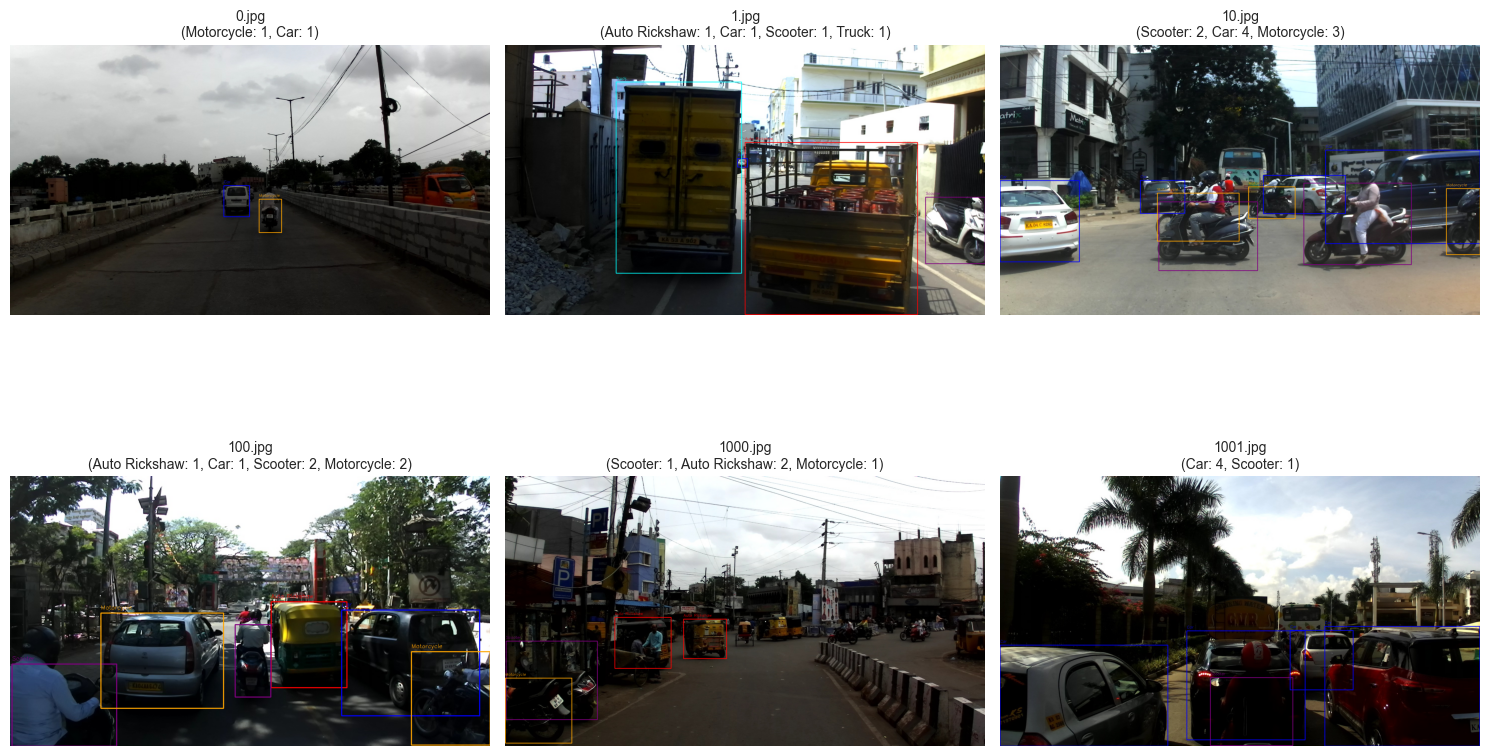

✅ Visualization saved as 'dataset_samples.png'

🎨 Class Color Legend:
   Red     : Auto Rickshaw
   Green   : Bus
   Blue    : Car
   Orange  : Motorcycle
   Purple  : Scooter
   Cyan    : Truck

✅ Dataset visualization complete!
📁 All dataset files are ready in: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data


In [18]:
import matplotlib.colors as mcolors

def visualize_dataset_samples(num_samples=6):
    """Visualize converted dataset samples with fixed color handling"""
    print(f"🖼️ Visualizing {num_samples} dataset samples...")
    
    # Get sample images and labels
    train_img_dir = YOLO_OUTPUT / "images" / "train"
    train_label_dir = YOLO_OUTPUT / "labels" / "train"
    
    img_files = list(train_img_dir.glob("*.jpg")) + list(train_img_dir.glob("*.png"))
    
    if not img_files:
        print("❌ No training images found for visualization")
        return
    
    # Limit to available images
    num_samples = min(num_samples, len(img_files))
    img_files = img_files[:num_samples]
    
    # Create subplots
    cols = min(3, num_samples)
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    
    # Handle different subplot arrangements
    if num_samples == 1:
        axes = [axes]
    elif rows == 1:
        if cols == 1:
            axes = [axes]
        # else axes is already correct for single row
    else:
        axes = axes.flatten()
    
    # Define colors for different classes (BGR format for OpenCV)
    class_colors = {
        0: (255, 0, 0),     # Red for auto_rickshaw
        1: (0, 255, 0),     # Green for bus
        2: (0, 0, 255),     # Blue for car
        3: (255, 165, 0),   # Orange for motorcycle
        4: (128, 0, 128),   # Purple for scooter
        5: (0, 255, 255)    # Cyan for truck
    }
    
    for idx, img_file in enumerate(img_files):
        try:
            # Load image
            img = cv2.imread(str(img_file))
            if img is None:
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]
            
            # Load corresponding label
            label_file = train_label_dir / f"{img_file.stem}.txt"
            
            bbox_count = 0
            class_counts = {}
            
            if label_file.exists():
                with open(label_file, 'r') as f:
                    lines = f.read().strip().split('\n')
                
                # Draw bounding boxes
                for line in lines:
                    if line.strip():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            center_x, center_y, width, height = map(float, parts[1:5])
                            
                            # Convert back to pixel coordinates
                            x1 = int((center_x - width/2) * w)
                            y1 = int((center_y - height/2) * h)
                            x2 = int((center_x + width/2) * w)
                            y2 = int((center_y + height/2) * h)
                            
                            # Get color for this class (convert BGR to RGB)
                            color_bgr = class_colors.get(class_id, (255, 0, 0))
                            color_rgb = (color_bgr[2], color_bgr[1], color_bgr[0])  # BGR to RGB
                            
                            # Draw rectangle
                            cv2.rectangle(img, (x1, y1), (x2, y2), color_bgr, 2)
                            
                            # Add label
                            if class_id < len(enhanced_converter.class_names):
                                class_name = enhanced_converter.class_names[class_id]
                                label_text = class_name.replace('_', ' ').title()
                                
                                # Count classes
                                if class_name not in class_counts:
                                    class_counts[class_name] = 0
                                class_counts[class_name] += 1
                                
                                cv2.putText(img, label_text, (x1, max(y1-10, 15)), 
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 1)
                            bbox_count += 1
            
            # Display image
            ax = axes[idx] if num_samples > 1 else axes[0]
            ax.imshow(img)
            
            # Create title with class counts
            title_parts = [f"{img_file.name}"]
            if class_counts:
                count_str = ", ".join([f"{cls.replace('_', ' ').title()}: {count}" 
                                     for cls, count in class_counts.items()])
                title_parts.append(f"({count_str})")
            else:
                title_parts.append(f"({bbox_count} objects)")
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            ax.axis('off')
            
        except Exception as e:
            print(f"Error processing {img_file.name}: {e}")
            continue
    
    # Hide unused subplots
    if num_samples < len(axes):
        for idx in range(num_samples, len(axes)):
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualization saved as 'dataset_samples.png'")

# Run the fixed visualization
visualize_dataset_samples(num_samples=6)

# Show class legend
print(f"\n🎨 Class Color Legend:")
class_names_display = ['Auto Rickshaw', 'Bus', 'Car', 'Motorcycle', 'Scooter', 'Truck']
colors_display = ['Red', 'Green', 'Blue', 'Orange', 'Purple', 'Cyan']
for i, (name, color) in enumerate(zip(class_names_display, colors_display)):
    print(f"   {color:8}: {name}")

print(f"\n✅ Dataset visualization complete!")
print(f"📁 All dataset files are ready in: {YOLO_OUTPUT}")

In [20]:
def create_dataset_yaml():
    """Create YOLO dataset configuration"""
    print("📝 Creating dataset.yaml...")
    
    # Count actual converted data
    train_count = len(list((YOLO_OUTPUT / "images" / "train").glob("*.jpg"))) + len(list((YOLO_OUTPUT / "images" / "train").glob("*.png")))
    val_count = len(list((YOLO_OUTPUT / "images" / "val").glob("*.jpg"))) + len(list((YOLO_OUTPUT / "images" / "val").glob("*.png")))
    test_count = len(list((YOLO_OUTPUT / "images" / "test").glob("*.jpg"))) + len(list((YOLO_OUTPUT / "images" / "test").glob("*.png")))
    
    print(f"📊 Dataset sizes:")
    print(f"   Train: {train_count} images")
    print(f"   Val: {val_count} images") 
    print(f"   Test: {test_count} images")
    
    if train_count == 0:
        print("❌ No training data found!")
        return None
    
    dataset_config = {
        'path': str(YOLO_OUTPUT.absolute()),
        'train': 'images/train',
        'val': 'images/val' if val_count > 0 else 'images/train',
        'test': 'images/test' if test_count > 0 else 'images/train',
        'nc': len(enhanced_converter.class_names),
        'names': enhanced_converter.class_names
    }
    
    # Save config
    config_file = YOLO_OUTPUT / "dataset.yaml"
    with open(config_file, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"✅ Created: {config_file}")
    
    # Display config
    print(f"\n📋 Dataset Configuration:")
    for key, value in dataset_config.items():
        print(f"   {key}: {value}")
    
    return config_file

# Create the missing dataset YAML
dataset_yaml_enhanced = create_dataset_yaml()

if dataset_yaml_enhanced:
    print(f"\n🎯 DATASET YAML CREATED!")
    print(f"   Path: {dataset_yaml_enhanced}")
else:
    print(f"\n❌ Failed to create dataset YAML")

📝 Creating dataset.yaml...
📊 Dataset sizes:
   Train: 3535 images
   Val: 884 images
   Test: 1083 images
✅ Created: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\dataset.yaml

📋 Dataset Configuration:
   path: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data
   train: images/train
   val: images/val
   test: images/test
   nc: 6
   names: ['auto_rickshaw', 'bus', 'car', 'motorcycle', 'scooter', 'truck']

🎯 DATASET YAML CREATED!
   Path: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\dataset.yaml


In [21]:
# Install ultralytics if needed
try:
    from ultralytics import YOLO
    print("✅ Ultralytics already installed")
except ImportError:
    print("📦 Installing ultralytics...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])
    from ultralytics import YOLO
    print("✅ Ultralytics installed successfully")

# Check system capabilities
import torch

print(f"\n🔧 System Information:")
print(f"   Python: {sys.version.split()[0]}")
print(f"   PyTorch: {torch.__version__}")

if torch.cuda.is_available():
    print(f"   🚀 GPU: {torch.cuda.get_device_name(0)}")
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"   💾 GPU Memory: {gpu_memory:.1f} GB")
    device = "cuda"
    print(f"   ⚡ Training will be FAST!")
else:
    print(f"   💻 Using CPU (no GPU detected)")
    device = "cpu"
    print(f"   ⏱️ Training will be slower but will work")

print(f"   🎯 Training device: {device}")

# Check if dataset YAML exists
if dataset_yaml_enhanced and dataset_yaml_enhanced.exists():
    print(f"   ✅ Dataset config: {dataset_yaml_enhanced}")
    
    # Load and verify dataset config
    with open(dataset_yaml_enhanced, 'r') as f:
        dataset_config = yaml.safe_load(f)
    
    print(f"   📊 Classes: {dataset_config['nc']}")
    print(f"   🚗 Vehicle types: {dataset_config['names']}")
    
    # Count total objects
    total_objects = sum(enhanced_converter.class_stats.values())
    total_images = sum(len(list((YOLO_OUTPUT / "images" / split).glob("*.jpg"))) 
                      for split in ['train', 'val', 'test'])
    
    print(f"   📈 Total images: {total_images}")
    print(f"   🎯 Total objects: {total_objects}")
    print(f"   📊 Avg objects/image: {total_objects/total_images:.1f}")
    
    print(f"\n✅ EVERYTHING READY FOR TRAINING!")
    
else:
    print(f"   ❌ Dataset config missing!")
    print(f"   🔧 Run Cell 8.3 first to create dataset.yaml")

✅ Ultralytics already installed

🔧 System Information:
   Python: 3.11.7
   PyTorch: 2.5.0+cpu
   💻 Using CPU (no GPU detected)
   ⏱️ Training will be slower but will work
   🎯 Training device: cpu
   ✅ Dataset config: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\dataset.yaml
   📊 Classes: 6
   🚗 Vehicle types: ['auto_rickshaw', 'bus', 'car', 'motorcycle', 'scooter', 'truck']
   📈 Total images: 5502
   🎯 Total objects: 24450
   📊 Avg objects/image: 4.4

✅ EVERYTHING READY FOR TRAINING!


In [22]:
def get_ultra_cpu_optimized_config():
    """Get ultra-optimized CPU training configuration"""
    print("⚙️ ULTRA CPU-OPTIMIZED CONFIGURATION")
    print("=" * 40)
    
    # Calculate dataset size impact
    total_images = sum(len(list((YOLO_OUTPUT / "images" / split).glob("*.jpg"))) 
                      for split in ['train', 'val', 'test'])
    
    print(f"📊 Dataset size: {total_images} images")
    
    # Ultra-optimized CPU configuration
    config = {
        'model': 'yolov8n.pt',     # Nano model - smallest/fastest
        'epochs': 30,              # Reduced epochs for CPU
        'batch': 1,                # Minimal batch size
        'imgsz': 320,              # Much smaller image size
        'patience': 5,             # Reduced patience
        'lr0': 0.005,              # Lower learning rate for stability
        'warmup_epochs': 1,        # Minimal warmup
        'save_period': 3,          # Save every 3 epochs (more frequent)
        'workers': 1,              # Single worker to avoid conflicts
        'device': 'cpu',
        'cache': False,            # No caching to save RAM
        'amp': False,              # No mixed precision
        'verbose': True,
        'single_cls': False,       # Multi-class detection
        'rect': False,             # No rectangular training
        'cos_lr': False,           # No cosine learning rate
        'overlap_mask': False,     # Disable for speed
        'mask_ratio': 4,           # Reduce mask processing
        'dropout': 0.0,            # No dropout for speed
        'val': True,               # Keep validation
        'plots': False,            # Disable plots for speed
        'save_json': False,        # No JSON saving
        'save_hybrid': False,      # No hybrid saving
        'conf': None,              # Default confidence
        'iou': 0.7,                # IoU threshold
        'max_det': 100,            # Max detections per image
        'half': False,             # No half precision on CPU
        'dnn': False,              # No OpenCV DNN
        'augment': False,          # Minimal augmentation
        'agnostic_nms': False,     # Class-specific NMS
        'retina_masks': False,     # No retina masks
        'boxes': True              # Keep bounding boxes
    }
    
    print(f"📋 Ultra-Optimized Settings:")
    key_settings = ['model', 'epochs', 'batch', 'imgsz', 'lr0', 'workers', 'save_period']
    for key in key_settings:
        print(f"   {key:15}: {config[key]}")
    
    # Estimate memory usage
    estimated_memory_per_image = (320 * 320 * 3 * 4) / (1024*1024)  # MB per image
    estimated_batch_memory = estimated_memory_per_image * config['batch']
    
    print(f"\n💾 Memory Estimation:")
    print(f"   Per image: ~{estimated_memory_per_image:.1f} MB")
    print(f"   Per batch: ~{estimated_batch_memory:.1f} MB")
    print(f"   Total RAM needed: ~2-4 GB")
    
    print(f"\n⏱️ Time Estimation:")
    print(f"   Training time: 1.5-3 hours")
    print(f"   Per epoch: ~3-6 minutes")
    print(f"   Checkpoints every 3 epochs (~15 minutes)")
    
    return config

# Get ultra-optimized configuration
ultra_cpu_config = get_ultra_cpu_optimized_config()

# Option for even more aggressive optimization
print(f"\n🔧 AGGRESSIVE OPTIMIZATION OPTIONS:")
print(f"   For slower systems:")
print(f"   ultra_cpu_config['imgsz'] = 256     # Even smaller images")
print(f"   ultra_cpu_config['epochs'] = 20     # Fewer epochs")
print(f"   ultra_cpu_config['patience'] = 3    # Earlier stopping")

# Let user choose
optimize_further = input(f"\nUse even more aggressive settings for slower CPU? (y/n): ").lower().strip()

if optimize_further == 'y':
    ultra_cpu_config.update({
        'imgsz': 256,
        'epochs': 20,
        'patience': 3,
        'save_period': 2,  # Save every 2 epochs
        'lr0': 0.003,      # Even lower learning rate
    })
    print(f"✅ Applied aggressive optimization:")
    print(f"   Image size: 256px")
    print(f"   Epochs: 20")
    print(f"   Estimated time: 45-90 minutes")

⚙️ ULTRA CPU-OPTIMIZED CONFIGURATION
📊 Dataset size: 5502 images
📋 Ultra-Optimized Settings:
   model          : yolov8n.pt
   epochs         : 30
   batch          : 1
   imgsz          : 320
   lr0            : 0.005
   workers        : 1
   save_period    : 3

💾 Memory Estimation:
   Per image: ~1.2 MB
   Per batch: ~1.2 MB
   Total RAM needed: ~2-4 GB

⏱️ Time Estimation:
   Training time: 1.5-3 hours
   Per epoch: ~3-6 minutes
   Checkpoints every 3 epochs (~15 minutes)

🔧 AGGRESSIVE OPTIMIZATION OPTIONS:
   For slower systems:
   ultra_cpu_config['imgsz'] = 256     # Even smaller images
   ultra_cpu_config['epochs'] = 20     # Fewer epochs
   ultra_cpu_config['patience'] = 3    # Earlier stopping
✅ Applied aggressive optimization:
   Image size: 256px
   Epochs: 20
   Estimated time: 45-90 minutes


In [24]:
import psutil
import gc
import time
from datetime import datetime, timedelta
import shutil

def check_system_resources():
    """Check available system resources"""
    print("🔍 CHECKING SYSTEM RESOURCES")
    print("=" * 30)
    
    # Check RAM
    memory = psutil.virtual_memory()
    available_gb = memory.available / (1024**3)
    total_gb = memory.total / (1024**3)
    
    print(f"💾 RAM Status:")
    print(f"   Total: {total_gb:.1f} GB")
    print(f"   Available: {available_gb:.1f} GB")
    print(f"   Used: {(total_gb - available_gb):.1f} GB")
    
    # Check disk space
    disk = psutil.disk_usage('.')
    free_gb = disk.free / (1024**3)
    
    print(f"💿 Disk Space:")
    print(f"   Free: {free_gb:.1f} GB")
    
    # Recommendations
    if available_gb < 2:
        print(f"⚠️ Warning: Low RAM. Consider closing other programs")
    elif available_gb < 4:
        print(f"💡 RAM is adequate but close unnecessary programs")
    else:
        print(f"✅ RAM looks good for training")
    
    if free_gb < 5:
        print(f"⚠️ Warning: Low disk space. Training needs ~2-3GB")
    else:
        print(f"✅ Disk space sufficient")
    
    return available_gb > 1.5 and free_gb > 3

def train_with_memory_management(config):
    """Train with memory management and monitoring"""
    print("🚀 STARTING MEMORY-EFFICIENT TRAINING")
    print("=" * 40)
    
    # Check resources first
    if not check_system_resources():
        print("❌ Insufficient resources. Please free up RAM/disk space.")
        return None, None, None
    
    # Force garbage collection
    gc.collect()
    
    # Create model
    print(f"📥 Loading {config['model']}...")
    model = YOLO(config['model'])
    
    # Setup run directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"indian_traffic_cpu_optimized_{timestamp}"
    
    print(f"📋 Training Configuration:")
    print(f"   🤖 Model: YOLOv8 Nano")
    print(f"   📏 Image size: {config['imgsz']}px")
    print(f"   📦 Batch size: {config['batch']}")
    print(f"   🔄 Epochs: {config['epochs']}")
    print(f"   💾 Save every: {config['save_period']} epochs")
    print(f"   📁 Run name: {run_name}")
    
    # Training parameters
    training_params = {
        'data': str(dataset_yaml_enhanced),
        'epochs': config['epochs'],
        'batch': config['batch'],
        'imgsz': config['imgsz'],
        'save': True,
        'project': str(Path.cwd() / "runs"),
        'name': run_name,
        'exist_ok': True,
        'patience': config['patience'],
        'device': 'cpu',
        'verbose': True,
        'save_period': config['save_period'],
        'lr0': config['lr0'],
        'warmup_epochs': config['warmup_epochs'],
        'workers': config['workers'],
        'cache': False,
        'plots': False,
        'save_json': False
    }
    
    print(f"\n🏃 Starting training...")
    estimated_completion = datetime.now() + timedelta(minutes=60)  # Estimate 1 hour
    print(f"⏱️ Estimated completion: {estimated_completion.strftime('%H:%M:%S')}")
    
    start_time = time.time()
    
    try:
        # Clear memory before training
        gc.collect()
        
        print(f"\n📊 Training Progress:")
        print(f"   Dataset: {sum(enhanced_converter.class_stats.values())} objects")
        print(f"   Classes: {len(enhanced_converter.class_names)}")
        print(f"   Starting now...")
        
        # Start training
        results = model.train(**training_params)
        
        end_time = time.time()
        training_duration = end_time - start_time
        
        print(f"\n🎉 TRAINING COMPLETED!")
        print(f"⏱️ Actual time: {timedelta(seconds=int(training_duration))}")
        
        # Find saved models
        runs_dir = Path.cwd() / "runs" / run_name
        best_model = runs_dir / "weights" / "best.pt"
        last_model = runs_dir / "weights" / "last.pt"
        
        if best_model.exists():
            model_size = best_model.stat().st_size / (1024*1024)
            print(f"🎯 Best model: {best_model}")
            print(f"📦 Size: {model_size:.1f} MB")
            
            # Create backup
            backup_dir = Path.cwd() / "trained_models"
            backup_dir.mkdir(exist_ok=True)
            backup_path = backup_dir / f"optimized_cpu_model_{timestamp}.pt"
            shutil.copy2(best_model, backup_path)
            print(f"💾 Backup: {backup_path}")
            
            return str(best_model), results, runs_dir
        
        elif last_model.exists():
            print(f"⚠️ Best model not found, using last checkpoint")
            print(f"📦 Last model: {last_model}")
            return str(last_model), results, runs_dir
        
        else:
            print(f"❌ No model weights found")
            return None, results, runs_dir
        
    except KeyboardInterrupt:
        print(f"\n⚠️ Training interrupted by user")
        print(f"💾 Partial results saved in: runs/{run_name}")
        return None, None, Path.cwd() / "runs" / run_name
        
    except Exception as e:
        print(f"\n❌ Training error: {e}")
        print(f"🔍 Error details: {str(e)}")
        print(f"📁 Check logs in: runs/{run_name}")
        return None, None, Path.cwd() / "runs" / run_name

# Show final configuration
print(f"\n📊 FINAL CONFIGURATION SUMMARY:")
print(f"   Image size: {ultra_cpu_config['imgsz']}px")
print(f"   Batch size: {ultra_cpu_config['batch']}")
print(f"   Epochs: {ultra_cpu_config['epochs']}")
print(f"   Model: YOLOv8 Nano")
print(f"   Save frequency: Every {ultra_cpu_config['save_period']} epochs")

# Confirm and start
print(f"\n🎯 Ready to start optimized CPU training!")
print(f"⏱️ Estimated time: {ultra_cpu_config['epochs'] * 3}-{ultra_cpu_config['epochs'] * 4} minutes")

start_now = input("Start training now? (y/n): ").lower().strip()

if start_now == 'y':
    print(f"\n🚀 TRAINING STARTED!")
    best_model_path, training_results, run_directory = train_with_memory_management(ultra_cpu_config)
    
    if best_model_path:
        print(f"\n✅ SUCCESS! Model ready for use!")
        print(f"🎯 Model path: {best_model_path}")
        print(f"📁 Training directory: {run_directory}")
        
        # Quick test of the model
        print(f"\n🧪 Model is ready for testing!")
        print(f"💡 You can now use this model in your Streamlit app")
        
    else:
        print(f"\n⚠️ Training incomplete or failed")
        if run_directory:
            print(f"📁 Check logs in: {run_directory}")
        
else:
    print(f"⏸️ Training postponed. Run when ready!")


📊 FINAL CONFIGURATION SUMMARY:
   Image size: 256px
   Batch size: 1
   Epochs: 20
   Model: YOLOv8 Nano
   Save frequency: Every 2 epochs

🎯 Ready to start optimized CPU training!
⏱️ Estimated time: 60-80 minutes

🚀 TRAINING STARTED!
🚀 STARTING MEMORY-EFFICIENT TRAINING
🔍 CHECKING SYSTEM RESOURCES
💾 RAM Status:
   Total: 15.6 GB
   Available: 3.5 GB
   Used: 12.2 GB
💿 Disk Space:
   Free: 299.3 GB
💡 RAM is adequate but close unnecessary programs
✅ Disk space sufficient
📥 Loading yolov8n.pt...
📋 Training Configuration:
   🤖 Model: YOLOv8 Nano
   📏 Image size: 256px
   📦 Batch size: 1
   🔄 Epochs: 20
   💾 Save every: 2 epochs
   📁 Run name: indian_traffic_cpu_optimized_20250524_215225

🏃 Starting training...
⏱️ Estimated completion: 22:52:25

📊 Training Progress:
   Dataset: 24450 objects
   Classes: 6
   Starting now...
Ultralytics 8.3.144  Python-3.11.7 torch-2.5.0+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=ra

train: Scanning C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\train... 3535 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3535/3535 [00:02<00:00, 1592.60it/s]


train: New cache created: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\train.cache
val: Fast image access  (ping: 0.10.0 ms, read: 2167.4317.6 MB/s, size: 509.1 KB)


val: Scanning C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\val... 884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 884/884 [00:00<00:00, 1605.57it/s]


val: New cache created: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\yolo_data\labels\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs\indian_traffic_cpu_optimized_20250524_215225
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.547      2.301      1.148          4        256: 100%|██████████| 3535/3535 [18:46<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:57<00:00,  7.68it/s]


                   all        884       3857      0.408      0.458      0.387      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.436      1.734       1.11          2        256: 100%|██████████| 3535/3535 [13:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:52<00:00,  8.37it/s]


                   all        884       3857      0.457      0.526      0.465      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.363      1.534      1.087         10        256: 100%|██████████| 3535/3535 [11:24<00:00,  5.17it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 13.96it/s]


                   all        884       3857      0.582      0.517      0.516      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.307      1.415      1.072          4        256: 100%|██████████| 3535/3535 [07:43<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 14.13it/s]

                   all        884       3857      0.586      0.549      0.565      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.277      1.366      1.059          1        256: 100%|██████████| 3535/3535 [07:40<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 13.87it/s]

                   all        884       3857      0.607      0.573      0.586      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.259        1.3      1.048         16        256: 100%|██████████| 3535/3535 [07:41<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:32<00:00, 13.79it/s]


                   all        884       3857      0.653      0.573      0.608       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.228      1.266      1.041          7        256: 100%|██████████| 3535/3535 [07:44<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 13.95it/s]

                   all        884       3857      0.632      0.583      0.611      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.213      1.237       1.03          3        256: 100%|██████████| 3535/3535 [07:47<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 14.09it/s]

                   all        884       3857       0.67      0.562      0.614      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.206      1.215       1.03         15        256: 100%|██████████| 3535/3535 [07:48<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 13.93it/s]


                   all        884       3857      0.664      0.582      0.637      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.175      1.174      1.015          1        256: 100%|██████████| 3535/3535 [07:42<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:42<00:00, 10.44it/s]


                   all        884       3857      0.697      0.581      0.645      0.459
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.185      1.122     0.9762          5        256: 100%|██████████| 3535/3535 [13:04<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:51<00:00,  8.53it/s]


                   all        884       3857      0.649      0.595      0.639      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.159      1.084     0.9681          5        256: 100%|██████████| 3535/3535 [13:15<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:54<00:00,  8.09it/s]

                   all        884       3857      0.674        0.6      0.652      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.134      1.048      0.969          2        256: 100%|██████████| 3535/3535 [13:02<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:51<00:00,  8.58it/s]

                   all        884       3857      0.701      0.585      0.649       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.116       1.03      0.958          1        256: 100%|██████████| 3535/3535 [13:11<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:50<00:00,  8.70it/s]

                   all        884       3857      0.701      0.599      0.655      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.115      1.016     0.9578          6        256: 100%|██████████| 3535/3535 [13:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:50<00:00,  8.70it/s]

                   all        884       3857      0.694      0.607      0.664      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.085     0.9904     0.9467          6        256: 100%|██████████| 3535/3535 [09:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 13.97it/s]

                   all        884       3857       0.72      0.594      0.664      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.079     0.9758     0.9464          3        256: 100%|██████████| 3535/3535 [07:38<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:32<00:00, 13.74it/s]

                   all        884       3857      0.734      0.601      0.673      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.059     0.9527     0.9418          4        256: 100%|██████████| 3535/3535 [07:37<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:31<00:00, 13.81it/s]

                   all        884       3857       0.71        0.6      0.673      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.047     0.9392     0.9399          8        256: 100%|██████████| 3535/3535 [07:40<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:32<00:00, 13.72it/s]

                   all        884       3857      0.729      0.589      0.676      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.041     0.9283     0.9382          5        256: 100%|██████████| 3535/3535 [09:44<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:51<00:00,  8.57it/s]

                   all        884       3857      0.715      0.602       0.68      0.495



20 epochs completed in 3.647 hours.
Optimizer stripped from C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs\indian_traffic_cpu_optimized_20250524_215225\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs\indian_traffic_cpu_optimized_20250524_215225\weights\best.pt, 6.2MB

Validating C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs\indian_traffic_cpu_optimized_20250524_215225\weights\best.pt...
Ultralytics 8.3.144  Python-3.11.7 torch-2.5.0+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 442/442 [00:46<00:00,  9.53it/s]

                   all        884       3857      0.715      0.602       0.68      0.495
         auto_rickshaw        371        610      0.854      0.698      0.813      0.646
                   bus        208        258      0.686      0.612      0.656      0.518
                   car        580       1120      0.764      0.737      0.768      0.595
            motorcycle        555        938      0.545       0.52      0.566      0.349
               scooter        424        698      0.818      0.399      0.615      0.357
                 truck        202        233      0.621      0.648      0.659      0.506
Speed: 0.3ms preprocess, 26.7ms inference, 0.0ms loss, 0.5ms postprocess per image



🎉 TRAINING COMPLETED!
⏱️ Actual time: 3:39:45
🎯 Best model: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs\indian_traffic_cpu_optimized_20250524_215225\weights\best.pt
📦 Size: 5.9 MB
💾 Backup: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\trained_models\optimized_cpu_model_20250524_215225.pt

✅ SUCCESS! Model ready for use!
🎯 Model path: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs\indian_traffic_cpu_optimized_20250524_215225\weights\best.pt
📁 Training directory: C:\Users\abhir\Downloads\urban\indian-traffic-ai\yolo\runs\indian_traffic_cpu_optimized_20250524_215225

🧪 Model is ready for testing!
💡 You can now use this model in your Streamlit app


In [25]:
def monitor_training_progress():
    """Monitor training progress from log files"""
    print("📊 TRAINING PROGRESS MONITOR")
    print("=" * 30)
    
    runs_dir = Path.cwd() / "runs"
    
    if not runs_dir.exists():
        print("❌ No training runs found")
        return
    
    # Find latest training run
    indian_traffic_runs = [d for d in runs_dir.iterdir() 
                          if d.is_dir() and 'indian_traffic_cpu' in d.name]
    
    if not indian_traffic_runs:
        print("❌ No Indian traffic training runs found")
        return
    
    latest_run = max(indian_traffic_runs, key=lambda x: x.stat().st_mtime)
    print(f"📂 Monitoring: {latest_run.name}")
    
    # Check for results and weights
    results_file = latest_run / "results.csv"
    weights_dir = latest_run / "weights"
    
    if results_file.exists():
        print(f"✅ Training results available")
        
        # Read and display latest metrics
        try:
            import pandas as pd
            df = pd.read_csv(results_file)
            if not df.empty:
                latest_epoch = df.iloc[-1]
                print(f"📈 Latest epoch: {int(latest_epoch.get('epoch', 0))}")
                if 'train/box_loss' in df.columns:
                    print(f"📉 Train loss: {latest_epoch.get('train/box_loss', 0):.4f}")
                if 'val/box_loss' in df.columns:
                    print(f"📉 Val loss: {latest_epoch.get('val/box_loss', 0):.4f}")
                if 'metrics/mAP50(B)' in df.columns:
                    print(f"🎯 mAP50: {latest_epoch.get('metrics/mAP50(B)', 0):.4f}")
        except:
            print("📊 Results file exists but couldn't parse")
    
    if weights_dir.exists():
        weight_files = list(weights_dir.glob("*.pt"))
        print(f"💾 Saved weights: {len(weight_files)} files")
        
        for weight_file in weight_files:
            size_mb = weight_file.stat().st_size / (1024*1024)
            print(f"   📦 {weight_file.name}: {size_mb:.1f} MB")
    
    print(f"\n💡 Run this cell periodically to check progress!")

# Run progress monitor
monitor_training_progress()

📊 TRAINING PROGRESS MONITOR
📂 Monitoring: indian_traffic_cpu_optimized_20250524_215225
✅ Training results available
📈 Latest epoch: 20
📉 Train loss: 1.0410
📉 Val loss: 0.9969
🎯 mAP50: 0.6796
💾 Saved weights: 12 files
   📦 best.pt: 5.9 MB
   📦 epoch0.pt: 17.6 MB
   📦 epoch10.pt: 17.6 MB
   📦 epoch12.pt: 17.6 MB
   📦 epoch14.pt: 17.6 MB
   📦 epoch16.pt: 17.6 MB
   📦 epoch18.pt: 17.6 MB
   📦 epoch2.pt: 17.6 MB
   📦 epoch4.pt: 17.6 MB
   📦 epoch6.pt: 17.6 MB
   📦 epoch8.pt: 17.6 MB
   📦 last.pt: 5.9 MB

💡 Run this cell periodically to check progress!
